In [1]:
%pylab inline
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqmodels import QLF_McGreer_2013

Populating the interactive namespace from numpy and matplotlib


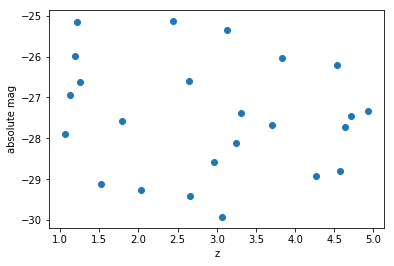

In [2]:
# set up a luminosity-redshift grid
M = AbsMagVar(UniformSampler(-30,-25),restWave=1450)
z = RedshiftVar(UniformSampler(1,5))
MzGrid = QsoSimGrid([M,z],(4,3),2)
scatter(MzGrid.z,MzGrid.absMag,)
xlabel('z')
ylabel('absolute mag')

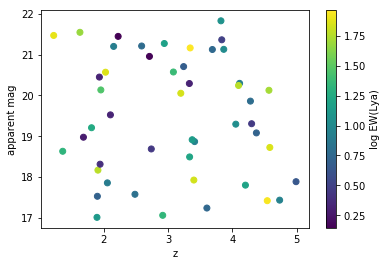

In [3]:
# set up a flux-redshift grid with Lya EW as a third dimension
m = AppMagVar(UniformSampler(17,22),'SDSS-i')
lya = GaussianLineEqWidthVar(UniformSampler(0,2),'LyaEW',1215.67,10.)
mzlyaGrid = QsoSimGrid([m,z,lya],(4,3,2),2)
scatter(mzlyaGrid.z,mzlyaGrid.appMag,c=mzlyaGrid.LyaEW)
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('log EW(Lya)')

In [4]:
# Generate m,z points by sampling from a model QLF
cosmo = QLF_McGreer_2013.cosmo
kcorr = sqbase.ContinuumKCorr('SDSS-i',1450)
qlfGrid =  generateQlfPoints(QLF_McGreer_2013,
                             (17,22),(4.5,5.3),kcorr,
                             skyArea=100)

integration returned  43  objects


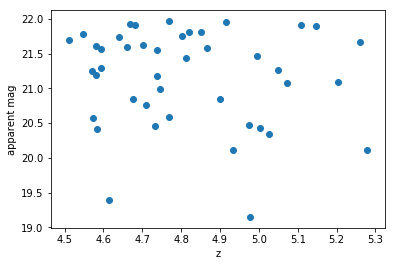

In [5]:
scatter(qlfGrid.z,qlfGrid.appMag)
xlabel('z')
ylabel('apparent mag')

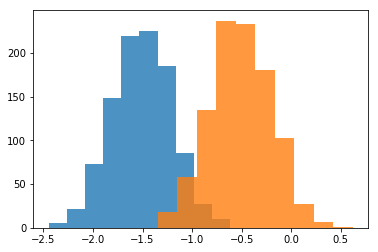

In [6]:
# test the canonical values for power law continuum slopes in FUV/NUV
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),GaussianSampler(-0.5,0.3)],[1215.])
contVals = contVar(1000)
_ = hist(contVals[:,0],alpha=0.8)
_ = hist(contVals[:,1],alpha=0.8)

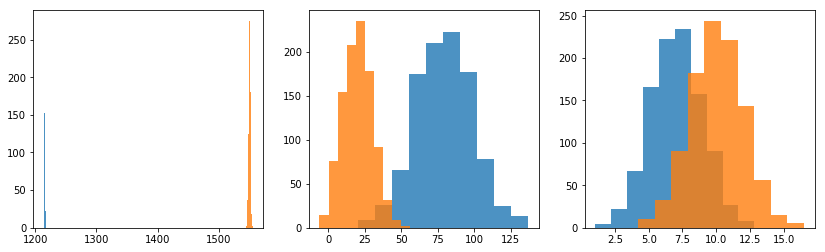

In [7]:
# Add gaussian emission lines
g = GaussianSampler
lya = [g(1215.7,0.5),g(80,20),g(7,2)]
civ = [g(1550.0,1.5),g(20,10),g(10,2)]
emLinesVar = GaussianEmissionLinesTemplateVar([lya,civ])
emLinesVals = emLinesVar(1000)
figure(figsize=(14,4))
for k in range(3):
    subplot(1,3,k+1)
    for j in range(2):
        hist(emLinesVals[:,j,k],alpha=0.8)

In [8]:
# add gaussian lines to the qlf grid
qlfGrid.addVar(emLinesVar)
print(qlfGrid)

   z     absMag   appMag   emLines [2,3]   
------- -------- ------- ------------------
4.93392 -26.4139 20.1086 1216.99 .. 7.68731
 4.5799 -25.1663 21.1986 1215.63 .. 6.87956
4.59248 -25.0823 21.2884 1216.54 .. 10.3671
4.59354 -24.7995 21.5717 1216.01 .. 6.55592
4.74676 -25.4489 20.9918 1215.22 .. 12.5716
5.10737 -24.6873 21.9081 1216.77 .. 10.4993
4.63924 -24.6567 21.7355 1215.36 .. 12.9683
4.61411 -26.9794 19.4012 1215.35 .. 8.64924
4.57279 -25.7843 20.5773 1215.96 .. 6.39188
4.73785 -24.8795 21.5573  1214.98 .. 9.9702
    ...      ...     ...                ...
4.68117  -24.495 21.9163 1215.57 .. 10.3149
5.26118 -24.9904 21.6672 1215.92 .. 10.1556
5.20242 -25.5435 21.0906 1215.43 .. 10.5771
4.73722 -25.2579 21.1787 1215.22 .. 9.31292
4.76834 -24.4846 21.9658 1214.71 .. 9.01544
4.70892 -25.6637 20.7602 1216.14 .. 12.4957
4.73353 -25.9717 20.4632 1215.68 .. 12.2634
4.67479 -25.5653 20.8431 1216.85 .. 11.2598
5.00402   -26.12 20.4323 1215.68 .. 11.4098
4.82137  -24.663 21.8108 1215.19

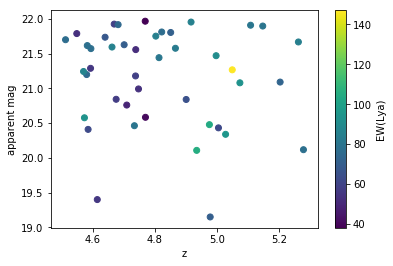

In [9]:
scatter(qlfGrid.z,qlfGrid.appMag,c=qlfGrid.emLines[:,0,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(Lya)')

In [10]:
# Now use the BOSS DR9 emission line template, including the Baldwin Effect
lineTemplate = generateBEffEmissionLines(qlfGrid.absMag)
lines = lineTemplate()
lines.shape

(43, 62, 3)

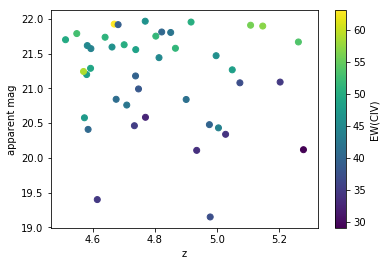

In [11]:
scatter(qlfGrid.z,qlfGrid.appMag,c=lines[:,13,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(CIV)')

In [12]:
vdblines = generateVdBCompositeEmLines(minEW=0)
vdblines = vdblines(qlfGrid.nObj)

using the following lines from VdB template: 
Ly{epsilon},CIII,Ly{beta},ArI,FeIII,CIII*,Ly{alpha},NV,SiII,OI,CII,SiIV,CIV,HeII,OIII],NIV,NIII],FeII,SiII,AlIII,SiIII],CIII],FeIII,FeIII,FeII,FeII,FeII,CII],[NeIV],[OII],FeII,AlII],MgII,FeII,OIII,HeI,FeI,FeII,[NeV],[NeV],FeII,[FeVII],[OII],[FeVII],FeII,FeII,[NeIII],HeI,[NeIII],[FeV],H{delta},FeII,FeII,[FeII],[FeII],H{gamma},[OIII],FeII,FeII,HeII,H{beta},FeII,[OIII],[OIII],[FeVII],[FeVI],[NI],[FeVII],FeII,[FeXIV],[ClIII],[FeVII],HeI,[FeVII],[OI],[OI],[NII],H{alpha},[NII],[SII],[SII],HeI,[ArIII],[OII],[NiIII]


In [13]:
wave = arange(3000,1e4,0.5)
z = 2.0
def quick_spec(emlines):
    lineWave,eqWidth,sigma = emlines.T * (1+z)
    spec = np.zeros_like(wave)
    A = eqWidth/(np.sqrt(2*np.pi)*sigma)
    twosig2 = 2*sigma**2
    nsig = np.sqrt(-2*np.log(1e-3/A))
    nsig = (nsig*np.array([[-1.],[1]])).T
    for i in range(lineWave.shape[0]):
        i1,i2 = np.searchsorted(wave,lineWave[i]+nsig[i]*sigma[i])
        if i2 != i1:
            lineprofile = A[i]*np.exp(-(wave[i1:i2]-lineWave[i])**2
                                       / twosig2[i])
            spec[i1:i2] += lineprofile
    return spec

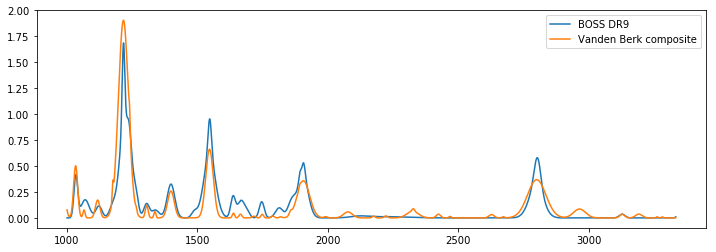

In [14]:
figure(figsize=(12,4))
plot(wave/(1+z),quick_spec(lines[0]),label='BOSS DR9')
plot(wave/(1+z),quick_spec(vdblines[0]),label='Vanden Berk composite')
legend()